In [22]:
import pandas as pd
import numpy as np

import pyspark.sql
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [23]:
# read in data

case = spark.read.csv("case.csv", header=True, inferSchema=True)
dept = spark.read.csv("dept.csv", header=True, inferSchema=True)
source = spark.read.csv("source.csv", header=True, inferSchema=True)

df = wrangle.wrangle_311(case, dept, source)

In [26]:
df.show(3, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 zipcode              | 78207                
 case_age             | 1317                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
-RECORD 1-------------------------

In [25]:
(df.count(), len(df.columns))

(855269, 20)

## 1. How many different cases are there, by department?

In [27]:
df.groupby("department").count().show(10, truncate=False)


+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |286287|
|Animal Care Services    |119362|
|Trans & Cap Improvements|97841 |
|Parks & Recreation      |19964 |
|Customer Service        |2889  |
|Metro Health            |5313  |
|City Council            |34    |
|DSD/Code Enforcement    |323579|
+------------------------+------+



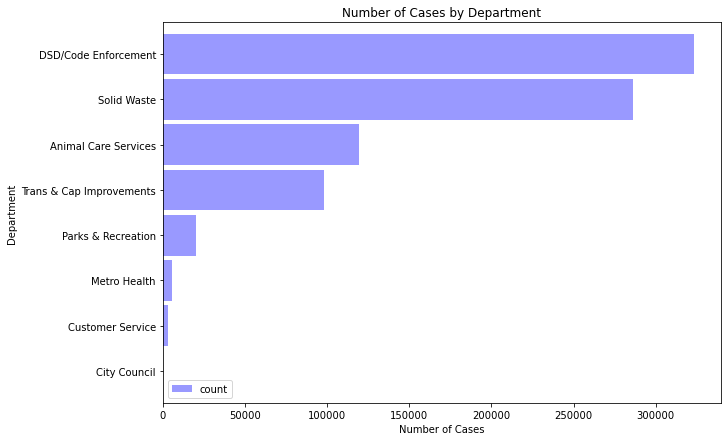

In [38]:
(
    df.groupby('department').count()
    .toPandas()
    .set_index('department')
    .sort_values(by = 'count', ascending = True)
    .plot.barh(color = 'blue', figsize = (10,7), width = .9, alpha=0.4)
)

plt.title('Number of Cases by Department')
plt.xlabel('Number of Cases')
plt.ylabel('Department')
plt.show()

## 2. Does the percentage of cases that are late vary by department?

## 3. On average, how late are the late cases by department?

In [44]:
(
df.where('case_late')
.groupBy('department')
.agg(mean('num_days_late').alias('n_days_late'))
.sort(desc('n_days_late'))
.show()
)

+--------------------+------------------+
|          department|       n_days_late|
+--------------------+------------------+
|    Customer Service| 88.18248182589822|
|DSD/Code Enforcement|49.506339986350454|
|Animal Care Services|  23.4467296347382|
|  Parks & Recreation|22.427807192724135|
|Trans & Cap Impro...|10.662950455078674|
|         Solid Waste|7.1471727895574135|
|        Metro Health| 6.494699602827871|
+--------------------+------------------+



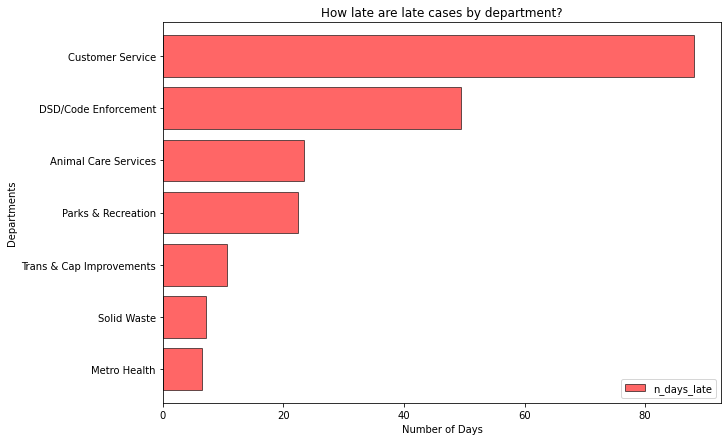

In [84]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('n_days_late'))
    .sort(desc('n_days_late'))
    .toPandas()
    .set_index('department')
    .sort_values(by = 'n_days_late', ascending = True)
    .plot.barh(width = 0.8, ec = 'black', alpha = .6, color = 'red', figsize = (10,7))
)
plt.title("How late are late cases by department?", fontsize = 12)
plt.xlabel("Number of Days")
plt.ylabel("Departments")
plt.show()

## 4. What is the service type that is the most late? Just for Parks & Rec?

In [50]:
(
df.where('case_late')
.groupBy('service_request_type')
.agg(mean('num_days_late').alias('n_days_late'))
.sort(desc('n_days_late'))
.show(10)
)

+--------------------+------------------+
|service_request_type|       n_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



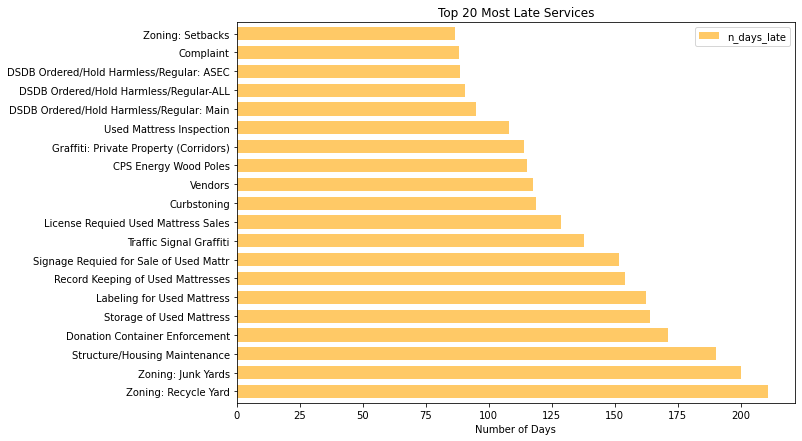

In [62]:
(
    df.where('case_late')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('n_days_late'))
    .sort(desc('n_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.barh(figsize = (10,7), width = .7, color = 'orange', alpha = 0.6)
)
# plt.xticks(rotation = 45, ha = 'right')
plt.ylabel("")
plt.xlabel("Number of Days")
plt.title('Top 20 Most Late Services', fontsize = 12)
plt.show()

In [64]:
# only for parks and rec
(
    df.where('case_late')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(5)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...| 76.60603677123078|
|Major Park Improv...| 75.79450367282354|
|Reservation Assis...|       66.03116319|
|Park Building Mai...|59.367469802695666|
| Sportfield Lighting|52.034858419575656|
+--------------------+------------------+
only showing top 5 rows



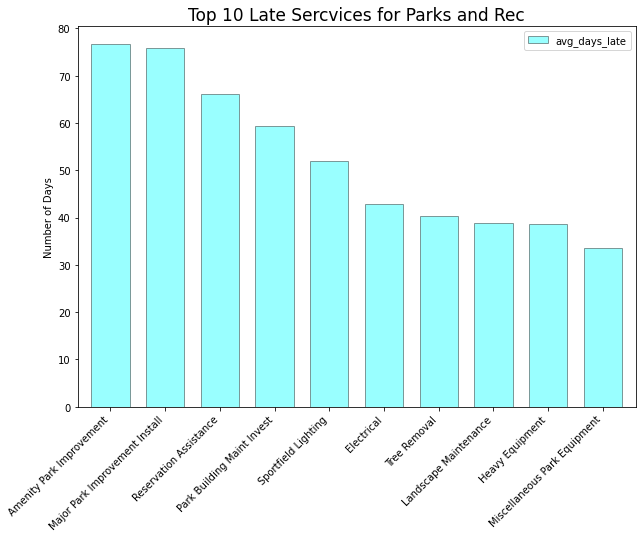

In [70]:
(
    df.where('case_late')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(10)
    .plot.bar(figsize = (10,7), width = .7, ec='black', color = 'cyan', alpha = 0.4)
)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel("")
plt.ylabel('Number of Days')
plt.title('Top 10 Late Sercvices for Parks and Rec', fontsize = 17)
plt.show()

## 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [71]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(truncate = False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |66403|
|Bandit Signs                          |32968|
|Front Or Side Yard Parking            |28920|
|Junk Vehicle On Private Property      |21649|
|Alley-Way Maintenance                 |20293|
|Right Of Way/Sidewalk Obstruction     |17836|
|Vacant Lot/Overgrown/Trash            |9497 |
|Minimum Housing-Owner Occupied        |8617 |
|Graffiti: Private Property (Corridors)|8525 |
|Minimum Housing-Tenant Occupied       |8104 |
|Dang. Premises/CL/SEC                 |8004 |
|"Vacant Lot-Private (12"")"           |7875 |
|Brush Violations                      |7530 |
|Permits Building                      |6950 |
|Vacant House Overgrown Yard           |6278 |
|Graffiti: Building                    |4572 |
|Low Hanging Limbs on Streets/Sidewalk |4107 |
|Graffiti Public Property              |4104 |
|CPS Energy W

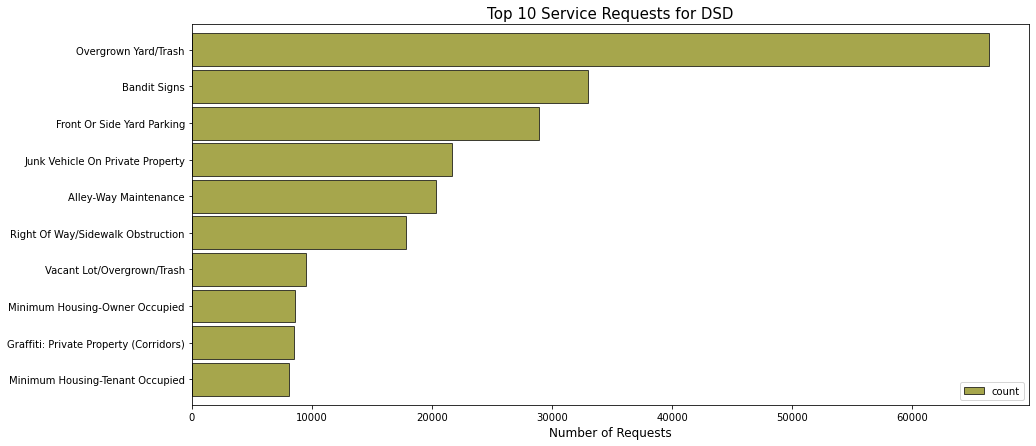

In [83]:
(
        df.filter(col('department') == 'DSD/Code Enforcement')
        .groupby('service_request_type').count()
        .sort(desc('count'))
        .toPandas()
        .set_index('service_request_type')
        .head(10)
        .sort_values(by = 'count', ascending = True)
        .plot.barh(figsize = (15,7), color = 'olive', width = 0.9, ec = 'black', alpha = .7)
    )
plt.title('Top 10 Service Requests for DSD', fontsize = 15)
plt.xlabel('Number of Requests', fontsize = 12)
plt.ylabel("")
plt.show()

## 6. Does whether or not its a weekend matter for when a case is opened/closed?

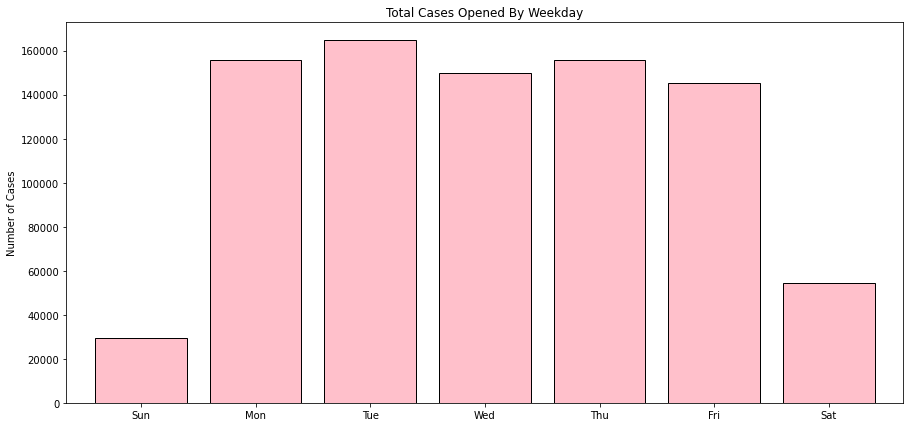

In [92]:
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
# the line above is an example of doing the date formatting with spark through the SimpleDateFormat api instead of with python
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    # convert weekday string to a categorical type with order
    # order the weekdays properly 
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=days, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar(figsize = (15,7),width=0.8, ec="black", color="pink")
)

plt.xticks(rotation=0)
plt.gca().set(
    xlabel="", ylabel="Number of Cases", title="Total Cases Opened By Weekday"
)
plt.show()


## 7. On average, how many cases are opened a day for the Customer Service department?

## 8. Does the number of service requests for the solid waste department vary by day of the week?